In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import timeit
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime

%matplotlib inline

# Polynomial Regression with Ridge regularization (general functions)

First, we define general functions that iterate over degree, lambda and evaluate the regression. After that we use these functions on our trip and weather data to predict demand. 

## 1. Finding an appropriate Degree

In [2]:
#import libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

#Firstly we want to iterate over the degree in order to find a good approximation of our data without overfitting
def iterating_over_degree(x, y, MAXdeg): 

    x_train, x_hold, y_train, y_hold = train_test_split(x, y, test_size=(0.2/0.7), random_state=34 ) #0.2/0.7 because we divided the set already in 70% train+holdout earlier

    err_train = []
    err_hold = []

    for deg in range(1, MAXdeg): #iterating over degree
        
        #create poly features
        Poly = PolynomialFeatures(degree = deg)
        X_train_poly = Poly.fit_transform(x_train)
        X_hold_poly = Poly.fit_transform(x_hold)

        #fit model
        model_L2 = Ridge(alpha = 0, normalize = True, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train_poly, y_train)

        #compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train_poly), y_train))
        err_hold.append(mean_squared_error(model_L2.predict(X_hold_poly), y_hold))

    #plotting errors
    plt.figure(figsize = (8,5))    
    plt.semilogy(range(1, MAXdeg), err_train, range(1, MAXdeg), err_hold)
    plt.legend(["Training", "Holdout"])
    plt.xlabel("Polynomial degree")
    plt.ylabel("Mean squared error")
    plt.show()

## 2. Finding an appropriate Lambda for the Ridge Regression

In [3]:
#After that we want to iterate over lambda/alpha in order to find a good regularization parameter
def iterating_over_lambda (x, y, deg, MINlambda, MAXlambda): #Min- and Maxlambda as Limits for Lambda over logarithmic space

    err_train = []
    err_hold = []
    
    x_train, x_hold, y_train, y_hold = train_test_split(x, y, test_size=(0.2/0.7), random_state=34 ) #0.2/0.7 because we divided the set already in 70% train+holdout earlier

    for lam in np.logspace(MINlambda,MAXlambda,100):
        
        #create poly features
        Poly = PolynomialFeatures(degree = deg)
        X_train_poly = Poly.fit_transform(x_train)
        X_hold_poly = Poly.fit_transform(x_hold)

        #fit model
        model_L2 = Ridge(alpha = lam, normalize = True, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(X_train_poly, y_train)

        #compute errors
        err_train.append(mean_squared_error(model_L2.predict(X_train_poly), y_train))
        err_hold.append(mean_squared_error(model_L2.predict(X_hold_poly), y_hold))

    #plotting errors
    plt.figure(figsize = (8,5))
    plt.loglog(np.logspace(MINlambda,MAXlambda,100), err_train, np.logspace(MINlambda,MAXlambda,100), err_hold)
    plt.legend(["Training", "Holdout"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

## 3. Evaluating the model

In [4]:
#Now we evaluate the model with given degree and lambda
def evaluate_L2(x,y,deg, lam):
   
    #create poly features
    Poly = PolynomialFeatures(degree = deg)
    X_poly = Poly.fit_transform(x)

    #fit model
    model_L2 = Ridge(alpha = lam, normalize = True, solver = 'lsqr') # select least squares regression as solver
    model_L2.fit(X_poly, y)
    
    #print the evaluation metrics
    print("Mean-Squared-Error: ", mean_squared_error(model_L2.predict(X_poly), y) )
    print("Mean-Absolute-Error: ", mean_absolute_error(model_L2.predict(X_poly), y) )

## Import our data

In [5]:
marburg = pd.read_pickle("../0_data/marburg_clean.pkl")
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
marburg_weather = pd.read_pickle("../0_data/weather/marburg_weather.pkl")
duisburg_weather = pd.read_pickle("../0_data/weather/duisburg_weather.pkl")
marburg_weather["h"]= marburg_weather.index
marburg_weather

,temperature,precipitation,cloud_coverage,wind_velocity,h
timestamp,,,,,
2019-01-20 00:00:00,-7.9,0.0,5,3.0,2019-01-20 00:00:00
2019-01-20 01:00:00,-8.3,0.0,0,2.6,2019-01-20 01:00:00
2019-01-20 02:00:00,-8.7,0.0,0,3.0,2019-01-20 02:00:00
2019-01-20 03:00:00,-8.9,0.0,0,3.1,2019-01-20 03:00:00
2019-01-20 04:00:00,-8.7,0.0,0,3.1,2019-01-20 04:00:00
...,...,...,...,...,...
2020-01-20 19:00:00,-1.5,0.0,0,1.7,2020-01-20 19:00:00
2020-01-20 20:00:00,-1.7,0.0,0,1.9,2020-01-20 20:00:00
2020-01-20 21:00:00,-2.3,0.0,0,1.8,2020-01-20 21:00:00


# Marburg

In [6]:
#creating new dataframe by hour with demand column
ma = pd.DataFrame(marburg.resample('H').count()["day"])
ma.rename(columns={'day': 'demand'}, inplace=True)

#creating possible features 
ma['dayofyear'] = ma.index.map(lambda datetime : datetime.dayofyear)
ma['week'] = ma.index.map(lambda datetime : datetime.week)
ma['weekday'] = ma.index.map(lambda datetime : datetime.weekday)
ma['is_weekday'] = ma['weekday'].map(lambda day : day < 5)
ma['hour'] = ma.index.map(lambda datetime : datetime.hour)

ma = ma.merge(marburg_weather, left_index=True, right_index=True) #Merging weather and bicycle data

## 1. Finding Degree

In [7]:
X_ma = ma[['temperature', 'hour', 'precipitation', 'week', 'weekday', 'is_weekday']]
y_ma = ma['demand']

X_train_ma, X_test_ma, y_train_ma, y_test_ma = train_test_split(X_ma, y_ma, test_size=0.3,random_state=34 )

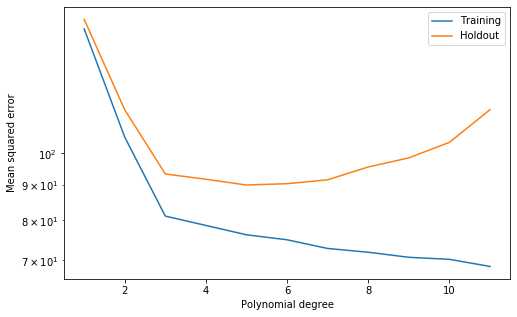

In [8]:
iterating_over_degree(X_train_ma,y_train_ma,12)

We see that there is only a significant improvement in the MSE up to a degree of 5.

## 2. Finding lambda

**Warning:** The following grid search can take up to several minutes.

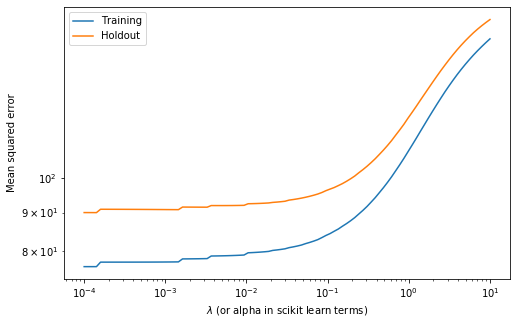

In [9]:
iterating_over_lambda(X_train_ma.values,y_train_ma.values,5,-4, 1)

We choose a lambda of 0.0001.

## 3. Evaluating Model

First we evaluate our model without the regularization parameter lambda:

In [10]:
evaluate_L2(X_test_ma,y_test_ma,5,0)

Mean-Squared-Error:  78.23859266241091
Mean-Absolute-Error:  6.50239876341439


Then we include regularization with the lambda value found above:

In [11]:
evaluate_L2(X_test_ma,y_test_ma,5,0.0001)

Mean-Squared-Error:  78.2417401033726
Mean-Absolute-Error:  6.500927199529462


Contrary to our expectation, adding a regularization does not significantly improve the evaluation metrics. This could be explained by our comparatively low degree of 5. Therefore, it does not help to improve our model and could be skipped in future calculations of the same form. 

# Duisburg

In [12]:
#creating new dataframe by hour with demand column
du = pd.DataFrame(duisburg.resample('H').count()["day"])
du.rename(columns={'day': 'demand'}, inplace=True)

#creating features 
du['dayofyear'] = du.index.map(lambda datetime : datetime.dayofyear)
du['week'] = du.index.map(lambda datetime : datetime.week)
du['weekday'] = du.index.map(lambda datetime : datetime.weekday)
du['is_weekday'] = du['weekday'].map(lambda day : day < 5)
du['hour'] = du.index.map(lambda datetime : datetime.hour)

du = du.merge(duisburg_weather, left_index=True, right_index=True) #merging data frames

## 1. Finding Degree

In [13]:
X_du = du[['temperature', 'hour', 'precipitation', 'week', 'weekday', 'is_weekday']]
y_du = du['demand']

X_train_du, X_test_du, y_train_du, y_test_du = train_test_split(X_du, y_du, test_size=0.3,random_state=34 )

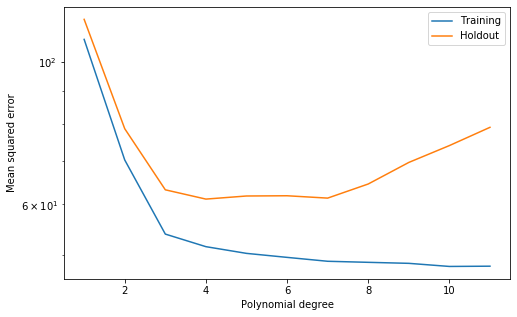

In [14]:
iterating_over_degree(X_train_du,y_train_du,12)

The graph shows that there is only a significant improvement in the mean squared error up to a degree of 7.

## 2. Find Lambda

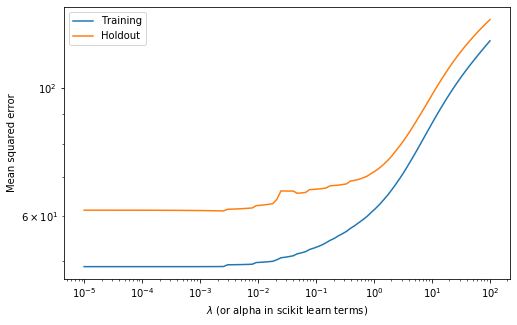

In [15]:
iterating_over_lambda(X_train_du.values,y_train_du.values,7,-5, 2)

We choose a lambda of 0.001.

## 3. Evaluating Model

First we evaluate our model without the regularization parameter lambda:

In [16]:
evaluate_L2(X_test_du,y_test_du,7,0)

Mean-Squared-Error:  48.438732748884206
Mean-Absolute-Error:  5.232759849720002


Then we include regularization with the lambda value found above:

In [17]:
evaluate_L2(X_test_du,y_test_du,7,0.001)

Mean-Squared-Error:  48.60419275181559
Mean-Absolute-Error:  5.244194090796023


As already observed in the Marburg data, adding a regularization does not significantly improve the evaluation metrics. This could be explained by our comparatively low degree of 7. Therefore, it does not help to improve our model and could be skipped in future calculations of the same form. 